In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from src.preprocessing import display_missing_values
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_theme(style="ticks", palette="pastel")

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

In [3]:
from fonctions import Dataset,group_fuel_types
from src.preprocessing import display_missing_values

In [4]:
train=Dataset("data/train.csv")
data_train=train.load_data()
test=Dataset("data/test.csv")
data_test=test.load_data()

In [5]:
from fonctions import Preprocessor,TrainPreprocessor,TestPreprocessor
train_preprocessor=TrainPreprocessor(data_train)
test_preprocessor=TestPreprocessor(data_test)

In [6]:
variables_continues=["Fuel consumption ","Electric range (km)","ec (cm3)","z (Wh/km)","W (mm)"]

In [7]:
for col in variables_continues:
    train_preprocessor.outlier_detection(col)
    test_preprocessor.outlier_detection(col)

In [8]:
train_preprocessor.fill_fuel_consumption()
train_preprocessor.fill_electric_range()
train_preprocessor.fill_engine_capacity()
train_preprocessor.fill_electric_consumption()
train_preprocessor.fill_category_type()
train_preprocessor.fill_wheel_base()
train_preprocessor.fill_At_1()
train_preprocessor.fill_At_2()
train_preprocessor.fill_mass()
train_preprocessor.fill_engine_power()
train_preprocessor.last_step()

test_preprocessor.fill_fuel_consumption()
test_preprocessor.fill_electric_range()
test_preprocessor.fill_engine_capacity()
test_preprocessor.fill_electric_consumption()
test_preprocessor.fill_category_type()
test_preprocessor.fill_wheel_base()
test_preprocessor.fill_At_1()
test_preprocessor.fill_At_2()
test_preprocessor.fill_mass()
test_preprocessor.fill_engine_power()
test_preprocessor.last_step()

In [9]:
data_train

,ID,VFN,Mp,Mh,Man,Tan,T,Mk,Cn,Ct,Cr,m (kg),Mt,Ewltp (g/km),W (mm),At1 (mm),At2 (mm),Ft,Fm,ec (cm3),ep (KW),z (Wh/km),Erwltp (g/km),Fuel consumption,Electric range (km),flag_Fuel consumption,flag_Electric range (km),flag_ec (cm3),flag_z (Wh/km),flag_W (mm)
0,0,IP-C519_2022_00008-WF0-1,FORD,FORD WERKE GMBH,FORD WERKE GMBH,e13*2007/46*1911*15,DEH,FORD,FOCUS,M1,M1,1387.00,1534.00,401.05,2700.00,1571.00,1576.00,PETROL,H,999.00,92.00,0.00,2.30,5.60,0.00,0,0,0,0,0
1,1,IP-MQB27ZZ_A2_0529-WVW-1,VOLKSWAGEN,VOLKSWAGEN,VOLKSWAGEN AG,e1*2007/46*1783*29,AW,VOLKSWAGEN,POLO,M1,M1,1172.00,1337.00,394.68,2552.00,1500.00,1483.00,PETROL,M,999.00,70.00,0.00,1.14,5.50,0.00,0,0,0,0,0
2,2,IP-MQB27ZZ_A1_0533-WVW-1,VOLKSWAGEN,VOLKSWAGEN,VOLKSWAGEN AG,e1*2007/46*1783*29,AW,VOLKSWAGEN,POLO,M1,M1,1204.00,1335.00,398.56,2552.00,1500.00,1483.00,PETROL,M,999.00,70.00,0.00,1.14,5.60,0.00,0,0,0,0,0
3,3,IP-04-U5Y-2018-1137,KIA,KIA SLOVAKIA,KIA SLOVAKIA SRO,e4*2007/46*1299*18,CD,KIA,PROCEED,M1,M1,1438.00,1588.00,479.47,2650.00,1555.00,1563.00,PETROL,M,1591.00,150.00,0.00,0.80,6.80,0.00,0,0,0,0,0
4,4,IP-MQB27ZZ_B2_0534-WVW-1,VOLKSWAGEN,VOLKSWAGEN,VOLKSWAGEN AG,e1*2007/46*1783*29,AW,VOLKSWAGEN,POLO,M1,M1,1207.00,1350.00,421.85,2552.00,1500.00,1483.00,PETROL,M,999.00,81.00,0.00,1.14,5.90,0.00,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7571644,7571644,IP-MLB42AZ_B0_0685-WAU-1,VOLKSWAGEN,AUDI AG,AUDI AG,e1*2007/46*1550*35,FY,AUDI,Q5,M1,M1,1815.00,2006.00,481.85,2829.00,1622.00,1626.00,DIESEL,H,1968.00,120.00,0.00,NaN,5.90,0.00,0,0,0,0,0
7571645,7571645,IP-MLB42AZ_B0_0685-WAU-1,VOLKSWAGEN,AUDI AG,AUDI AG,e1*2007/46*1550*35,FY,AUDI,Q5,M1,M1,1815.00,2028.00,486.40,2829.00,1622.00,1626.00,DIESEL,H,1968.00,120.00,0.00,NaN,5.90,0.00,0,0,0,0,0
7571646,7571646,IP-MLB42AZ_B0_0685-WAU-1,VOLKSWAGEN,AUDI AG,AUDI AG,e1*2007/46*1550*35,FY,AUDI,Q5,M1,M1,1815.00,2006.00,487.87,2829.00,1622.00,1626.00,DIESEL,H,1968.00,120.00,0.00,NaN,5.90,0.00,0,0,0,0,0
7571647,7571647,IP-K14A1RTP6DAF_00-JN1-1,RENAULT-NISSAN-MITSUBISHI,NISSAN AUTOMOTIVE EUROPE,NISSAN AUTOMOTIVE EUROPE SAS,e3*2007/46*0523*03,K14-LPG,NISSAN,NISSAN MICRA,M1,M1,1240.00,NaN,350.80,2525.00,1510.00,1520.00,LPG,B,999.00,68.00,0.00,0.80,6.20,0.00,0,0,0,0,0


### Test de non-linéarité des variables quantitatives 

In [10]:
others=[col for col in data_train.columns if col not in variables_continues]

In [11]:
poly = PolynomialFeatures(degree=2,)

# Application de la transformation aux variables continues
variables_continues_transformees = poly.fit_transform(data_train[variables_continues])

data_train_transforme = pd.DataFrame(variables_continues_transformees, columns=poly.get_feature_names_out(variables_continues))
data_train= pd.concat([data_train[others],data_train_transforme], axis=1)



In [13]:
variables_continues_transformees = poly.fit_transform(data_test[variables_continues])

data_test_transforme = pd.DataFrame(variables_continues_transformees, columns=poly.get_feature_names_out(variables_continues))
data_test= pd.concat([data_test[list(filter(lambda x: x !='Ewltp (g/km)',others))],data_train_transforme], axis=1)

In [14]:
data_train = train_preprocessor.encode_that_var("Ct")
data_train = train_preprocessor.encode_that_var("Cr")
data_test = test_preprocessor.encode_that_var("Ct")
data_test = test_preprocessor.encode_that_var("Cr")

In [15]:
def create_conforme(df):
    df['conforme'] = df['Tan'].isna()
    df['conforme'] = df['conforme'].apply(lambda x: 1 if x==False else 0)
    df.drop(columns='Tan', inplace=True)
    pass
def compute_surface(obs):
    max_largeur= max(obs['At1 (mm)'], obs['At2 (mm)'])
    return obs['W (mm)']*obs['At1 (mm)'] if max_largeur == obs['At1 (mm)'] else obs['W (mm)'] * obs['At2 (mm)']

def create_surface(df):
    df['surface']= df.apply(compute_surface, axis=1)
    pass

def group_fuel_types(category: str):
    if category in ['PETROL/ELECTRIC', 'DIESEL/ELECTRIC']:
        return "HYBRID"
    elif category in ['NG-BIOMETHANE', 'HYDROGEN', 'NG','E85']:
        return "BIO-FUEL"
    elif category in ['PETROL','LPG'] :
        return 'PETROL'
    else:
        return category
def create_carburant(df):
    df['carburant']= df['Ft'].apply(group_fuel_types)
    df.drop(columns='Ft',inplace=True)

In [16]:
create_conforme(data_train)
create_surface(data_train)
create_carburant(data_train)

create_conforme(data_test)
create_surface(data_test)
create_carburant(data_test)

In [17]:
data_train = train_preprocessor.encode_that_var("carburant")
data_test = test_preprocessor.encode_that_var("carburant")

In [18]:
drop_this=['VFN', 'Mp', 'Mh', 'Man', 'T', 'Mk', 'Cn','Mt','W (mm)', 'At1 (mm)', 'At2 (mm)','Fm','Erwltp (g/km)']

data_train.drop(columns=drop_this, inplace=True)
data_test.drop(columns=drop_this, inplace=True)

In [19]:
data_train.drop(columns='ID',inplace=True)

In [20]:
list_vars=["Ewltp (g/km)", "m (kg)","ec (cm3)", "ep (KW)", "z (Wh/km)", "Fuel consumption ","Electric range (km)", "surface"]

<function matplotlib.pyplot.show(close=None, block=None)>

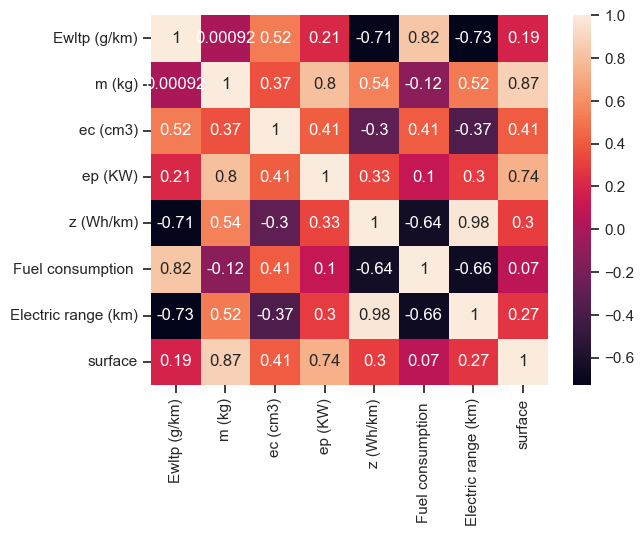

<Figure size 2000x2000 with 0 Axes>

In [21]:
sns.heatmap(data_train[list_vars].corr(method='spearman'),annot=True)
plt.figure(figsize=(20,20))
plt.show

In [ ]:
data_train.info()

In [ ]:
# data_train.drop(columns='z (Wh/km)',inplace=True)
# data_test.drop(columns='z (Wh/km)',inplace=True)

### Exploratory Data Analysis

In [22]:
from sklearn.linear_model import LassoCV, ElasticNetCV

In [23]:
train, test = train_test_split(data_train, test_size=0.33, random_state=42)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

X_train, y_train = train.drop(columns=["Ewltp (g/km)"]), train["Ewltp (g/km)"]
X_test, y_test = test.drop(columns=["Ewltp (g/km)"]), test["Ewltp (g/km)"]

In [24]:
lasso = LassoCV(cv=5,)
lasso.fit(X_train, y_train)

# Affichez les coefficients sélectionnés
selected_features = X_train.columns[lasso.coef_ != 0]
print("Variables sélectionnées par Adaptive LASSO :")
print(selected_features)

Variables sélectionnées par Adaptive LASSO :
Index(['m (kg)', 'ec (cm3)', 'z (Wh/km)', 'surface'], dtype='object')


In [25]:
elastic_net = ElasticNetCV(cv=5, random_state=42, l1_ratio=0.8)
elastic_net.fit(X_train, y_train)

# Affichez les coefficients sélectionnés
selected_features = X_train.columns[elastic_net.coef_ != 0]
print("Variables sélectionnées par Adaptive LASSO :")
print(selected_features)

Variables sélectionnées par Adaptive LASSO :
Index(['m (kg)', 'ec (cm3)', 'z (Wh/km)', 'surface'], dtype='object')


In [26]:
import xgboost as xgb

In [27]:
import numba
from numba import cuda

In [28]:
@numba.jit
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

C:\Users\jeann\AppData\Local\Temp\ipykernel_11448\13295361.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def evaluate_model(model, X_test, y_test):


In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 1000,
        'seed': 0
    }

In [ ]:
space_bis={'max_depth': hp.quniform("max_depth", 3, 18, 1),
           'n_estimators': 1500,
           'learning_rate':hp.uniform("learning_rate",0.1,0.30)
           

}

In [ ]:
@numba.jit
def objective(space):
    clf=xgb.XGBRegressor(objective="reg:squarederror",
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), eval_metric="mae")
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,
            verbose=False)
    

    y_pred = clf.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print ("SCORE:", mae)
    return {'loss': mae, 'status': STATUS_OK }

In [ ]:
@numba.jit
def objective_bis(space):
    clf=xgb.XGBRegressor(objective="reg:squarederror",
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']),max_iter=3000, eval_metric="mae")
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,
            verbose=False)
    

    y_pred = clf.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print ("SCORE:", mae)
    return {'loss': mae, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective_bis,
                        space = space_bis,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [29]:
@numba.jit
def train_xgboost(X,y,n_estimators=1000 ,objective='reg:squarederror',max_depth=10):
    xgboost_model=xgb.XGBRegressor(n_estimators=n_estimators ,objective=objective,max_depth=max_depth,eval_metric='mae')
    xgboost_model.fit(X, y, )
    return xgboost_model

C:\Users\jeann\AppData\Local\Temp\ipykernel_11448\2459840689.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def train_xgboost(X,y,n_estimators=1000 ,objective='reg:squarederror',max_depth=10):


In [30]:
xgboost_model=train_xgboost(X_train,y_train)

C:\Users\jeann\AppData\Local\Temp\ipykernel_11448\2459840689.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "train_xgboost" failed type inference due to: non-precise type pyobject
During: typing of argument at C:\Users\jeann\AppData\Local\Temp\ipykernel_11448\2459840689.py (1)

File "..\..\..\..\AppData\Local\Temp\ipykernel_11448\2459840689.py", line 1:
<source missing, REPL/exec in use?>

  @numba.jit
c:\Users\jeann\Desktop\M2\New Data Mining Challenge\Projet_Mining\.venv_mining\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "train_xgboost" was compiled in object mode without forceobj=True.

File "..\..\..\..\AppData\Local\Temp\ipykernel_11448\2459840689.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
c:\Users\jeann\Desktop\M2\New Data Mining Challenge\Projet_Mining\.venv_mining\lib\site-packages\numba\core\object_mode_passes.py:161: NumbaDeprecati

In [31]:
mae=evaluate_model(xgboost_model,X_test,y_test)

C:\Users\jeann\AppData\Local\Temp\ipykernel_11448\13295361.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "evaluate_model" failed type inference due to: Untyped global name 'mean_absolute_error': Cannot determine Numba type of <class 'function'>

File "..\..\..\..\AppData\Local\Temp\ipykernel_11448\13295361.py", line 4:
<source missing, REPL/exec in use?>

  @numba.jit
c:\Users\jeann\Desktop\M2\New Data Mining Challenge\Projet_Mining\.venv_mining\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "evaluate_model" was compiled in object mode without forceobj=True.

File "..\..\..\..\AppData\Local\Temp\ipykernel_11448\13295361.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
c:\Users\jeann\Desktop\M2\New Data Mining Challenge\Projet_Mining\.venv_mining\lib\site-packages\numba\core\object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopy

In [32]:
mae

3.3739737241174703

In [ ]:
xgboost_model_full=train_xgboost(data_train.drop(columns=["Ewltp (g/km)"]),data_train["Ewltp (g/km)"])

In [ ]:
X_true_test=data_test.drop(columns=["ID"])

In [ ]:
y_true_pred=xgboost_model.predict(X_true_test)

In [ ]:
data_test_to_submit=pd.concat([data_test["ID"],pd.DataFrame(y_true_pred,columns=["Ewltp (g/km)"])],axis=1)
data_test_to_submit.to_csv("data/xgboost_results6.csv", index=False)

In [ ]:
@numba.jit
def train_random_forest(X,y,n_estimators=1000,max_samples=10000 ,criterion='absolute_error',max_depth=10):
    #rf_model=RandomForestRegressor(n_estimators=n_estimators, max_samples=max_samples ,criterion=criterion,max_depth=max_depth)
    rf_model=RandomForestRegressor(criterion="absolute_error")
    rf_model.fit(X, y)
    return rf_model

In [ ]:
rf_model=train_random_forest(X_train,y_train)

mae=evaluate_model(rf_model,X_test,y_test)
print("Mean Absolute Error:", mae)

In [33]:
@numba.jit
def train_hist_gradient_boosting(X,y,loss="absolute_error",max_iter=3000, learning_rate=0.22,max_depth=10):
    hgbgb_model=HistGradientBoostingRegressor(loss=loss,max_iter=max_iter, learning_rate=learning_rate, max_depth=max_depth,interaction_cst="pairwise")
    hgbgb_model.fit(X,y)
    return hgbgb_model

C:\Users\jeann\AppData\Local\Temp\ipykernel_11448\3881279681.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def train_hist_gradient_boosting(X,y,loss="absolute_error",max_iter=3000, learning_rate=0.22,max_depth=10):


In [34]:
hgbgb_model=train_hist_gradient_boosting(X_train,y_train)

mae=evaluate_model(hgbgb_model,X_test,y_test)
print(f"Mean Absolute Error : {mae}")

KeyboardInterrupt: 

In [ ]:
hgbgb_model.n_iter_

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor


In [ ]:
# Créez un modèle de régression de base (par exemple, un arbre de régression)
@numba.jit
def train_adaboost_regressor(max_depth=7,n_estimators=1000, learning_rate=.2, random_state=42) -> AdaBoostRegressor:
    base_regressor = DecisionTreeRegressor(max_depth=max_depth)

    # Créez un modèle AdaBoostRegressor en utilisant le modèle de base
    adaboost_regressor = AdaBoostRegressor(base_regressor, n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)

    # Entraînez le modèle AdaBoost sur l'ensemble d'entraînement
    adaboost_regressor.fit(X_train, y_train)
    return adaboost_regressor


In [ ]:
adaboost_model=train_adaboost_regressor()

mae=evaluate_model(adaboost_model,X_test,y_test)
print(f"Mean Absolute Error : {mae}")

In [ ]:
X_true_test=data_test.drop(columns=['ID'])

In [ ]:
data_test["ID"]=data_test["ID"].apply(int)

In [ ]:
data_test["Ewltp (g/km)"] = xgboost_model.predict(X_true_test)
data_test[["ID","Ewltp (g/km)"]].to_csv("data/xgboost_results4.csv", index=False)

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
hgboost_model=HistGradientBoostingRegressor(max_iter=1000,learning_rate=0.23,max_depth=7,loss="absolute_error",random_state=42,l2_regularization=0.5, validation_fraction=0.2)

In [ ]:
# Entraînez le modèle sur les données d'entraînement
hgboost_model.fit(X_train, y_train)

# Prédisez sur les données de test
y_pred = hgboost_model.predict(X_test)

# Évaluez le modèle en utilisant la MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
dtregressor_model=DecisionTreeRegressor(criterion='absolute_error')

In [ ]:
dtregressor_model.fit(X_train, y_train)

# Prédisez sur les données de test
y_pred = dtregressor_model.predict(X_test)

# Évaluez le modèle en utilisant la MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

In [ ]:
import lightgbm as lgb

In [ ]:

# Créez un ensemble de données LightGBM
train_data = lgb.Dataset(X_train, label=y_train)

# Définissez les paramètres du modèle
params = {
    "objective": "regression",  # Régression
    "metric": "mae",  # Métrique d'erreur : Mean Absolute Error
    "boosting_type": "gbdt",  # Type de boosting (Gradient Boosting Decision Tree)
    "num_leaves": 31,  # Nombre maximum de feuilles dans un arbre
    "learning_rate": 0.1,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 10,
    "verbose": -1
}

# Entraînez le modèle
num_round = 1000  # Nombre d'itérations (vous pouvez ajuster selon vos besoins)
bst = lgb.train(params, train_data, num_round)

# Faites des prédictions sur l'ensemble de test
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Évaluez le modèle
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (mae): {mae}")

